In [3]:
import pandas as pd

df = pd.read_csv("data/dnd_chars_all.tsv", sep="\t")

In [4]:
df.drop(columns=["ip", "finger", "hash"], inplace=True)

In [ ]:
df.head()
df.columns

0        10
1        10
2        21
3        16
4        16
         ..
10889    13
10890    16
10891    19
10892    14
10893    13
Name: AC, Length: 10894, dtype: int64

In [5]:
cdf = df.dropna(subset=["justClass", "race", "processedRace"]).copy()
cdf["justClass_expanded"] = cdf["justClass"].str.split("|")
cdf_expand = cdf.explode("justClass_expanded")
cdf_expand["normalized_race"] = cdf_expand["processedRace"].str.strip().str.lower()
cdf_expand["normalized_class"] = cdf_expand["justClass_expanded"].str.strip().str.lower()
cdf_expand["normalized_background"] = cdf_expand["background"].str.strip().str.lower()
cdf_expand.head()

,name,race,background,date,class,justClass,subclass,level,feats,HP,...,good,lawful,processedRace,processedSpells,processedWeapons,alias,justClass_expanded,normalized_race,normalized_class,normalized_background
0,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T20:02:11Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,Fey Touched|War Caster|Metamagic Adept,146,...,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Sorcerer,dwarf,sorcerer,guild member - justice
0,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T20:02:11Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,Fey Touched|War Caster|Metamagic Adept,146,...,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Cleric,dwarf,cleric,guild member - justice
1,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T19:43:25Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,NaN,133,...,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Sorcerer,dwarf,sorcerer,guild member - justice
1,ee1e382c,Hill Dwarf,Guild Member - Justice,2022-08-23T19:43:25Z,Sorcerer 13|Cleric 1,Sorcerer|Cleric,Clockwork Soul|Order Domain,14,NaN,133,...,NaN,NaN,Dwarf,Alarm*1|Protection from Evil and Good*1|Comman...,"Crossbow, Light|Dagger",thirsty_davinci,Cleric,dwarf,cleric,guild member - justice
2,f1f6ff43,Human,Noble,2022-08-22T14:57:09Z,Fighter 13,Fighter,Eldritch Knight,13,Heavy Armor Master,140,...,NaN,NaN,Human,Prestidigitation*0|Mage Hand*0|Blade Ward*0|Li...,"Longsword|Dagger|Crossbow, Light|Mace",cool_bhabha,Fighter,human,fighter,noble


In [21]:
import matplotlib.pyplot as plt

In [ ]:

race_counts = cdf_expand["normalized_race"].value_counts()
races_to_keep = race_counts[race_counts > 100].index
pivot_table = pd.crosstab(cdf_expand["normalized_race"], cdf_expand["normalized_class"])
pivot_table_clean = pivot_table.loc[races_to_keep]
pivot_table_clean.T.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Race Distribution per Class")
plt.xlabel("Class")
plt.ylabel("Number of Characters")
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection  import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [65]:
column_transformer = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(sparse_output=False), ["normalized_race", "normalized_background", "good", "lawful", "countryCode"]),
    ("num", StandardScaler(), ['Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha'])
])
classifier_target = cdf_expand["normalized_class"]
classifier_features = cdf_expand[["normalized_race", "normalized_background", "good", "lawful", "countryCode", 'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha']]
counts = classifier_target.value_counts()
min_samples = 50
frequent_classes = counts[counts >= min_samples].index
mask = classifier_target.isin(frequent_classes)
classifier_target_filtered = classifier_target[mask]
classifier_features_filtered = classifier_features[mask]

In [82]:
#binary classifier for fighter vs non-fighter
_binary_classifier_target = (classifier_target_filtered == "fighter").astype(int)

classifier_encoded_features = column_transformer.fit_transform(classifier_features_filtered)
classifier_encoded_features_df = pd.DataFrame(classifier_encoded_features, columns=column_transformer.get_feature_names_out(classifier_features.columns))
X_train, X_test, y_train, y_test = train_test_split(classifier_encoded_features_df, _binary_classifier_target, test_size=0.2, random_state=42)

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
dummy_predictions = dummy_classifier.predict(X_test)
print("Dummy Classifier:")
print("Classification Report:\n", classification_report(y_test, dummy_predictions))
confusion = confusion_matrix(y_test, dummy_predictions)
print("Confusion Matrix:\n", confusion)

unbalanced_logistic_classifier = LogisticRegression(max_iter=1000, random_state=42)
unbalanced_logistic_classifier.fit(X_train, y_train)
logistic_predictions = unbalanced_logistic_classifier.predict(X_test)
print("Unbanalced Logistic Regression:")
print("Classification Report:\n", classification_report(y_test, logistic_predictions))
confusion = confusion_matrix(y_test, logistic_predictions)
print("Confusion Matrix:\n", confusion)


balanced_logistic_classifier = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
balanced_logistic_classifier.fit(X_train, y_train)
logistic_predictions = balanced_logistic_classifier.predict(X_test)
print("Banalced Logistic Regression:")
print("Classification Report:\n", classification_report(y_test, logistic_predictions))
confusion = confusion_matrix(y_test, logistic_predictions)
print("Confusion Matrix:\n", confusion)


rf_unbalanced = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)
rf_unbalanced.fit(X_train, y_train)
rf_predictions = rf_unbalanced.predict(X_test)

print("Unbalanced Random Forest:")
print("Classification Report:\n", classification_report(y_test, rf_predictions))
confusion = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix:\n", confusion)


rf_balanced = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced'
)
rf_balanced.fit(X_train, y_train)
rf_predictions = rf_balanced.predict(X_test)

print("Balanced Random Forest:")
print("Classification Report:\n", classification_report(y_test, rf_predictions))
confusion = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix:\n", confusion)

Dummy Classifier:
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      1968
           1       0.00      0.00      0.00       292

    accuracy                           0.87      2260
   macro avg       0.44      0.50      0.47      2260
weighted avg       0.76      0.87      0.81      2260

Confusion Matrix:
 [[1968    0]
 [ 292    0]]


/home/arst/RiderProjects/data-experiments/classification/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/arst/RiderProjects/data-experiments/classification/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/arst/RiderProjects/data-experiments/classification/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

Unbanalced Logistic Regression:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1968
           1       0.71      0.30      0.43       292

    accuracy                           0.89      2260
   macro avg       0.81      0.64      0.68      2260
weighted avg       0.88      0.89      0.87      2260

Confusion Matrix:
 [[1931   37]
 [ 203   89]]
Banalced Logistic Regression:
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.76      0.85      1968
           1       0.34      0.82      0.48       292

    accuracy                           0.77      2260
   macro avg       0.65      0.79      0.67      2260
weighted avg       0.89      0.77      0.80      2260

Confusion Matrix:
 [[1501  467]
 [  52  240]]
Unbalanced Random Forest:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      

In [ ]:
label_encoder = LabelEncoder()



classifier_features = cdf_expand[["normalized_race", "normalized_background", "good", "lawful", "countryCode", 'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha']]
counts = classifier_target.value_counts()
min_samples = 50
frequent_classes = counts[counts >= min_samples].index
mask = classifier_target.isin(frequent_classes)
classifier_target_filtered = classifier_target[mask]
classifier_features_filtered = classifier_features[mask]

classifier_target_encoded = label_encoder.fit_transform(classifier_target_filtered)
classifier_encoded_features = column_transformer.fit_transform(classifier_features_filtered)
classifier_encoded_features_df = pd.DataFrame(classifier_encoded_features, columns=column_transformer.get_feature_names_out(classifier_features.columns))
X_train, X_test, y_train, y_test = train_test_split(classifier_encoded_features_df, classifier_target_encoded, test_size=0.2, random_state=42)

In [52]:
print(f"Original classes: {classifier_target_filtered.nunique()}")
print(f"After filtering: {classifier_target_filtered.nunique()}")
print(f"Samples removed: {len(classifier_target) - len(classifier_target_filtered)}")

classifier_target_filtered.value_counts(normalize=True) * 100

Original classes: 13
After filtering: 13
Samples removed: 84


normalized_class
fighter      13.551071
rogue        12.108338
cleric        9.152062
barbarian     8.629846
paladin       7.912905
wizard        6.939281
ranger        6.868472
bard          6.691450
warlock       6.647194
druid         6.594087
monk          6.558683
sorcerer      6.346256
artificer     2.000354
Name: proportion, dtype: float64

In [53]:
counts = classifier_target_filtered.value_counts()
max_count = counts.max()
min_count = counts.min()
imbalance_ratio = max_count / min_count
print(f"Imbalance ratio: {imbalance_ratio:.2f} (1.0 = perfectly balanced)")

Imbalance ratio: 6.77 (1.0 = perfectly balanced)


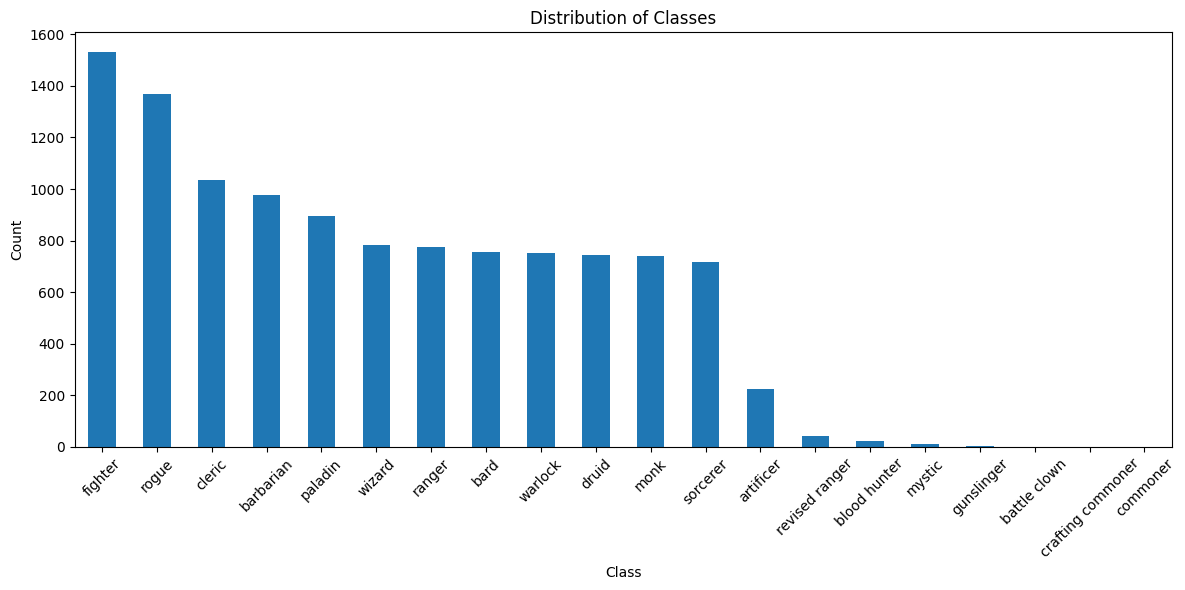

In [54]:
plt.figure(figsize=(12, 6))
classifier_target.value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
#baseline
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
cross_val_score(dummy_classifier, X_train, y_train, cv=5, scoring='accuracy').mean()

np.float64(0.13708782463477823)

In [64]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(random_state=42)

sgd_classifier.fit(X_train, y_train)
predictions = cross_val_predict(sgd_classifier, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, predictions)
cm
class_names = label_encoder.classes_
report = classification_report(y_train, predictions, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   artificer       0.55      0.38      0.45       176
   barbarian       0.54      0.53      0.53       769
        bard       0.44      0.46      0.45       602
      cleric       0.61      0.70      0.65       819
       druid       0.57      0.43      0.49       597
     fighter       0.47      0.39      0.43      1239
        monk       0.41      0.33      0.36       601
     paladin       0.50      0.72      0.59       725
      ranger       0.39      0.34      0.36       634
       rogue       0.47      0.65      0.55      1107
    sorcerer       0.43      0.30      0.36       563
     warlock       0.34      0.26      0.30       590
      wizard       0.64      0.67      0.66       616

    accuracy                           0.49      9038
   macro avg       0.49      0.47      0.48      9038
weighted avg       0.49      0.49      0.49      9038



In [59]:

model = LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


/home/arst/RiderProjects/data-experiments/classification/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
classifier_encoded_features_df

In [ ]:
unique_classes = pd.unique(y_test)
print(f"Unique classes in y_test: {unique_classes}")
print(f"Number of unique classes in y_test: {len(unique_classes)}")

In [50]:
from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

decoded_predictions = label_encoder.inverse_transform(predictions)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.60
